1. Load the necessary libraries:

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import accuracy_score

import talib


2. Load your dataset:

In [2]:
def get_features():
    df = pd.read_csv('./data/BTCUSDT_1h.csv')  # replace with your file path

    

    # List of periods
    periods = [4, 24, 48, 100, 200]

    # loop through periods
    for period in periods:

        # Price indicators
        # price % of ema
        p_ema = talib.EMA(df['close'].values, timeperiod=period)
        df[f'p_ema_{period}'] = (df['close'] - p_ema) / p_ema * 100

        # RSI
        df[f'p_rsi_{period}'] = talib.RSI(df['close'].values, timeperiod=period)

        # TRIX
        df[f'p_trix_{period}'] = talib.TRIX(df['close'].values, timeperiod=period)

        # SD
        p_sd = talib.STDDEV(df['close'].values, timeperiod=period)
        df[f'p_sd_{period}'] = p_sd / df['close'] * 100

        # ATR
        p_atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)
        df[f'p_atr_{period}'] = p_atr / df['close'] * 100

        # ROC
        df[f'p_roc_{period}'] = talib.ROC(df['close'].values, timeperiod=period)

        # Interaction Features:
        df[f'p_interaction_{period}'] = df[f'p_roc_{period}'] * df[f'p_atr_{period}']

        # Volume indicators
        v_ema = talib.EMA(df['volume'], timeperiod=period)

        # volume % of ema
        df[f'v_ema_{period}'] = (df['volume'] - v_ema) / v_ema * 100

        # RSI
        df[f'v_rsi_{period}'] = talib.RSI(df['volume'].values, timeperiod=period)

        # ROC
        df[f'v_roc_{period}'] = talib.ROC(df['volume'].values, timeperiod=period)

        # price volume interaction
        df[f'pv_interaction_{period}'] = df[f'p_roc_{period}'] * df[f'v_roc_{period}']


    return df

def get_target_next_close(df, target_shift = 10):
    target_treshold = 0.01
    conditions = [
        (df['close'].shift(target_shift * -1) > df['close'] * (1+target_treshold )),
        (df['close'].shift(target_shift * -1) < df['close'] * (1-target_treshold)),
        (df['close'].shift(target_shift * -1) >= df['close'] * (1-target_treshold)) & 
        (df['close'].shift(target_shift * -1) <= df['close'] * (1+target_treshold))
    ]
    values = [1, -1, 0]
    df['target'] = np.select(conditions, values)
    df = df.dropna()
    return df
    

df = get_features()
df = get_target_next_close(df)
print(df.head(10))
print(df.tail(10))

                          date      open      high       low     close  \
598  2021-07-23 21:00:00+00:00  32457.86  32648.00  32417.10  32581.19   
599  2021-07-23 22:00:00+00:00  32581.20  33300.00  32549.45  33117.26   
600  2021-07-23 23:00:00+00:00  33117.27  33650.00  33060.00  33634.46   
601  2021-07-24 00:00:00+00:00  33631.74  33790.00  33379.81  33543.18   
602  2021-07-24 01:00:00+00:00  33543.19  33648.35  33401.00  33589.99   
603  2021-07-24 02:00:00+00:00  33590.00  33758.88  33560.99  33643.66   
604  2021-07-24 03:00:00+00:00  33643.66  33676.80  33512.01  33647.97   
605  2021-07-24 04:00:00+00:00  33647.97  33850.00  33580.00  33657.87   
606  2021-07-24 05:00:00+00:00  33657.88  33750.00  33550.50  33724.10   
607  2021-07-24 06:00:00+00:00  33723.95  33930.52  33681.93  33861.24   

        volume   p_ema_4    p_rsi_4  p_trix_4    p_sd_4  ...  p_trix_200  \
598  14019.809  0.508047  77.934050  0.055385  0.573500  ...   -0.025100   
599  44685.610  1.285926  90.8585

In [83]:
df.groupby(['target']).count()

,date,open,high,low,close,volume,p_ema_4,p_rsi_4,p_trix_4,p_sd_4,...,p_rsi_200,p_trix_200,p_sd_200,p_atr_200,p_roc_200,p_interaction_200,v_ema_200,v_rsi_200,v_roc_200,pv_interaction_200
target,,,,,,,,,,,,,,,,,,,,,
-1,2785,2785,2785,2785,2785,2785,2785,2785,2785,2785,...,2785,2785,2785,2785,2785,2785,2785,2785,2785,2785
0,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240,...,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240
1,2726,2726,2726,2726,2726,2726,2726,2726,2726,2726,...,2726,2726,2726,2726,2726,2726,2726,2726,2726,2726


In [84]:
# list(df.columns)

3. Feature Engineering:

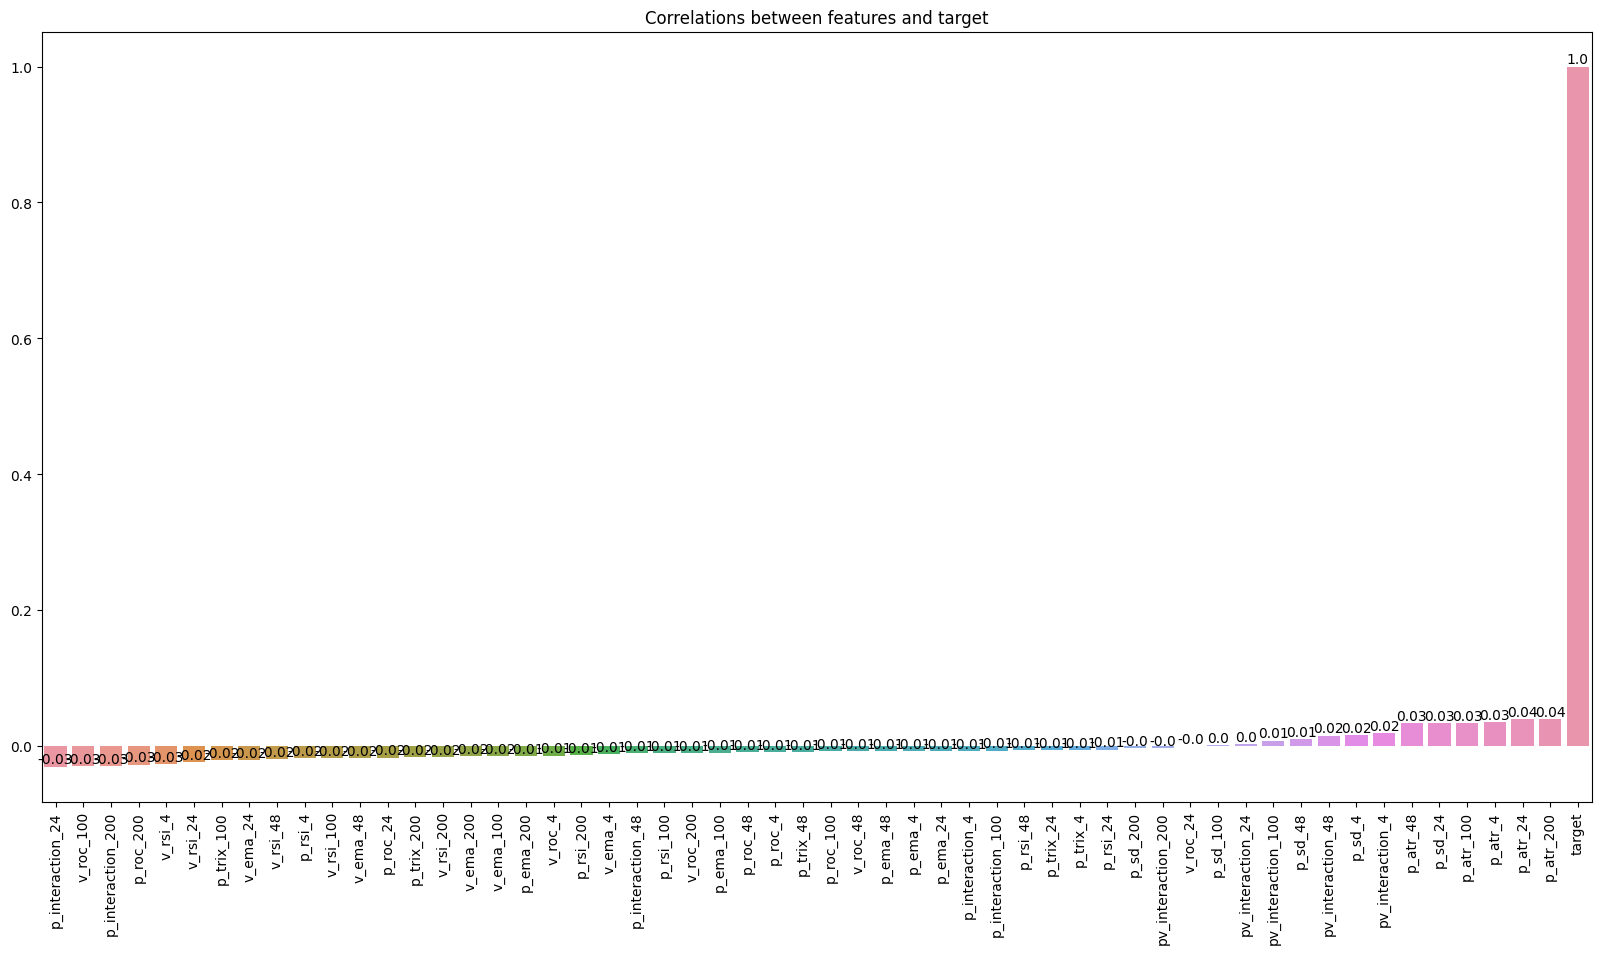

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# remove columns
drop_cols = ['date', 'high', 'low', 'open', 'close', 'volume']
# drop_cols = ['date']
df_tmp = df.drop(drop_cols, axis=1)

correlations = df_tmp.corr()['target'].sort_values()

# plot number of correlations with target
plt.figure(figsize=(20, 10))
sns.barplot(x=correlations.index, y=correlations.values)
plt.xticks(rotation=90)
# add value labels
for i, v in enumerate(correlations.values):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom', fontsize=10)

plt.title('Correlations between features and target')
plt.show()

In [86]:
# Splitting the data
drop_cols = ['date', 'high', 'low', 'open', 'close', 'volume', 'target']
X = df.drop(drop_cols, axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [87]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Using bagging with decision trees as the base classifier
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging_clf.fit(X_train, y_train)

# Making predictions
y_pred = bagging_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Bagging Classifier: {accuracy:.2f}")

Accuracy of the Bagging Classifier: 0.70


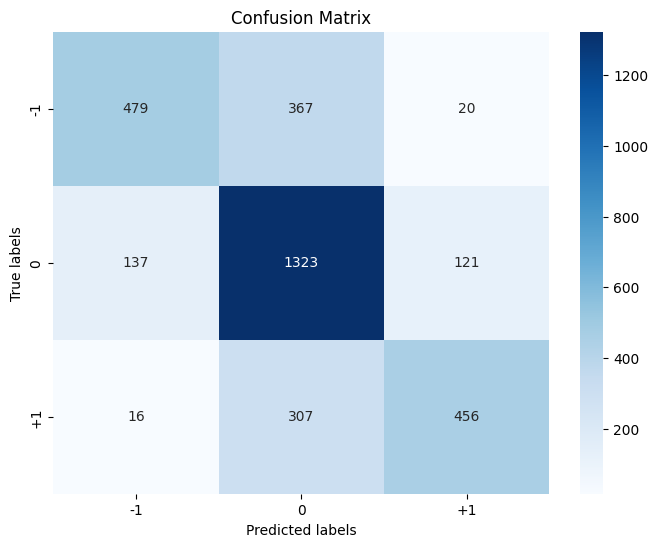


Classification Report:
               precision    recall  f1-score   support

          -1       0.76      0.55      0.64       866
           0       0.66      0.84      0.74      1581
           1       0.76      0.59      0.66       779

    accuracy                           0.70      3226
   macro avg       0.73      0.66      0.68      3226
weighted avg       0.71      0.70      0.69      3226



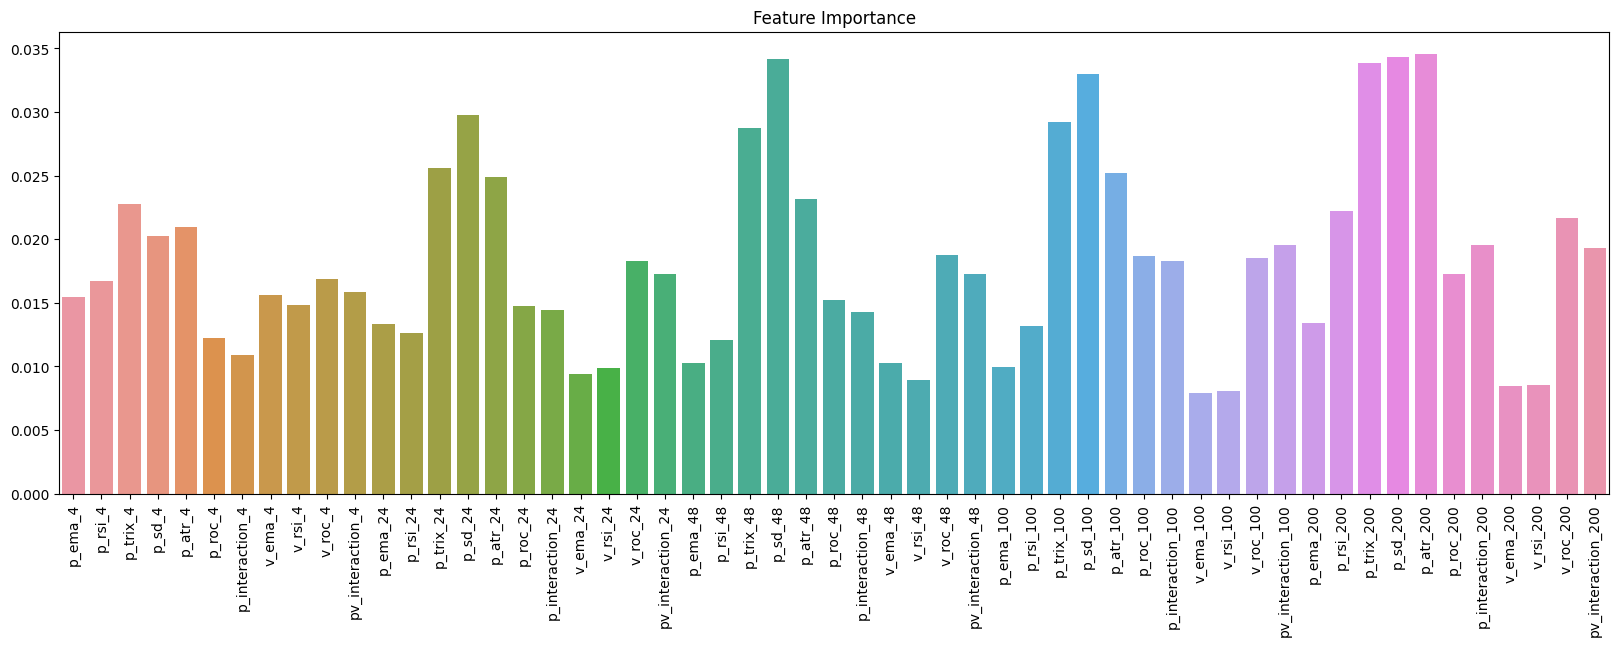

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['-1', '0', '+1'], 
            yticklabels=['-1', '0', '+1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 2. Feature Importance
# Since our base estimator is a decision tree, we can obtain feature importances.
# We average feature importance over all the base estimators to get an average importance.

# Collecting importances from each tree
importances = np.array([tree.feature_importances_ for tree in bagging_clf.estimators_])

# Averaging over trees
avg_importance = importances.mean(axis=0)

plt.figure(figsize=(20, 6))
sns.barplot(x=X.columns, y=avg_importance)
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()

# Calculate evaluation table
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score





----

In [4]:
df = get_features()
df = get_target_next_close(df)
print(df.head(3))
print(df.tail(3))

                          date      open     high       low     close  \
598  2021-07-23 21:00:00+00:00  32457.86  32648.0  32417.10  32581.19   
599  2021-07-23 22:00:00+00:00  32581.20  33300.0  32549.45  33117.26   
600  2021-07-23 23:00:00+00:00  33117.27  33650.0  33060.00  33634.46   

        volume   p_ema_4    p_rsi_4  p_trix_4    p_sd_4  ...  p_trix_200  \
598  14019.809  0.508047  77.934050  0.055385  0.573500  ...   -0.025100   
599  44685.610  1.285926  90.858521  0.215865  0.991633  ...   -0.024966   
600  35615.491  1.701125  94.786635  0.423978  1.389871  ...   -0.024826   

     p_sd_200  p_atr_200  p_roc_200  p_interaction_200   v_ema_200  v_rsi_200  \
598  2.507742   0.938945   2.450967           2.301324  -31.737831  49.840550   
599  2.491571   0.930460   4.295523           3.996811  115.057417  50.652589   
600  2.494742   0.920342   6.191505           5.698301   70.196605  50.409997   

      v_roc_200  pv_interaction_200  target  
598  -68.837166         -168.71